In [1]:
import tensorflow as tf
import numpy as np


DATASET

The dataset used is an EuroSat dataset from Kaggle: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset

The classes used in this experiment are:
AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential,

Sealake and river are excluded as they are not related with deforestaion

In [2]:
DATA_DIR= r"D:\University\sem5\Deep Learning\dataset"

In [3]:
def train_val_dataset():
    
    training_dataset=tf.keras.utils.image_dataset_from_directory(
        directory=DATA_DIR,
        image_size=(150,150),
        batch_size=32,
        label_mode= "categorical",
        validation_split=0.1,
        subset="training",
        seed=42
    )
    
    
    validation_set= tf.keras.utils.image_dataset_from_directory(
        directory= DATA_DIR,
        image_size=(150,150),
        batch_size=32,
        label_mode="categorical",
        validation_split=0.1,
        subset="validation",
        seed=42
    )
    
    return training_dataset, validation_set

In [4]:
training_dataset, validation_dataset= train_val_dataset()

Found 21500 files belonging to 8 classes.
Using 19350 files for training.
Found 21500 files belonging to 8 classes.
Using 2150 files for validation.


In [5]:
for images, labels in training_dataset.take(1):
    print("Labels shape:", labels.shape)
    print("Sample labels:", labels[0])


Labels shape: (32, 8)
Sample labels: tf.Tensor([0. 0. 1. 0. 0. 0. 0. 0.], shape=(8,), dtype=float32)


In [6]:
for images, labels in training_dataset:
    example_batch_images=images
    example_batch_labels=labels
    
    
print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

print(f"Maximum pixel value of images : {np.max(example_batch_images)}\n")
print (f"Shape of batch of images: {example_batch_images.shape}")
print(f"SHape of batch of labels : {example_batch_labels.shape} ")

Maximum pixel value of images: 255.0

Shape of batch of images: (22, 150, 150, 3)
Shape of batch of labels: (22, 8)
Maximum pixel value of images : 255.0

Shape of batch of images: (22, 150, 150, 3)
SHape of batch of labels : (22, 8) 


In [7]:
classnames= training_dataset.class_names
classnames

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential']

In [8]:
augmentation=tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2, fill_mode="reflect"),
    tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="reflect"),
    tf.keras.layers.RandomZoom(0.2, fill_mode="reflect")
])


In [9]:
def create_model():
    model= tf.keras.models.Sequential([
        tf.keras.layers.Input((150,150,3)),
        augmentation,
        tf.keras.layers.Rescaling((1./255)),
        tf.keras.layers.Conv2D(64,(3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64,(3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model

In [10]:
model= create_model()

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                 

In [ ]:
""""
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        if logs["accuracy"]>=0.94 and logs["val_accuracy"]>=0.82:
            self.model.stop_training=True
"""

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Train your model
with tf.device('/GPU:0'):
    history = model.fit(
        training_dataset,
        epochs=10,
        validation_data=validation_dataset
    )

# Get true labels and predictions
y_true = []
y_pred = []

for x, y in validation_dataset:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Epoch 1/10


605/605 [==============================] - 351s 573ms/step - loss: 1.3844 - accuracy: 0.4717 - val_loss: 0.9764 - val_accuracy: 0.6488
Epoch 2/10
605/605 [==============================] - 351s 579ms/step - loss: 1.0270 - accuracy: 0.6308 - val_loss: 0.8189 - val_accuracy: 0.6874
Epoch 3/10
605/605 [==============================] - 1057s 2s/step - loss: 0.8966 - accuracy: 0.6775 - val_loss: 0.7440 - val_accuracy: 0.7260
Epoch 4/10
605/605 [==============================] - 283s 468ms/step - loss: 0.8141 - accuracy: 0.7106 - val_loss: 0.6441 - val_accuracy: 0.7600
Epoch 5/10
605/605 [==============================] - 314s 519ms/step - loss: 0.7704 - accuracy: 0.7283 - val_loss: 0.7140 - val_accuracy: 0.7470
Epoch 6/10
605/605 [==============================] - 273s 451ms/step - loss: 0.7202 - accuracy: 0.7471 - val_loss: 0.5509 - val_accuracy: 0.7963
Epoch 7/10
605/605 [==============================] - 276s 455ms/step - loss: 0.6879 - accuracy: 0.7616 - val_loss: 0.5465 -

In [14]:
model.evaluate(validation_dataset)

68/68 [==============================] - 8s 109ms/step - loss: 0.5711 - accuracy: 0.7884


[0.5711068511009216, 0.7883720993995667]

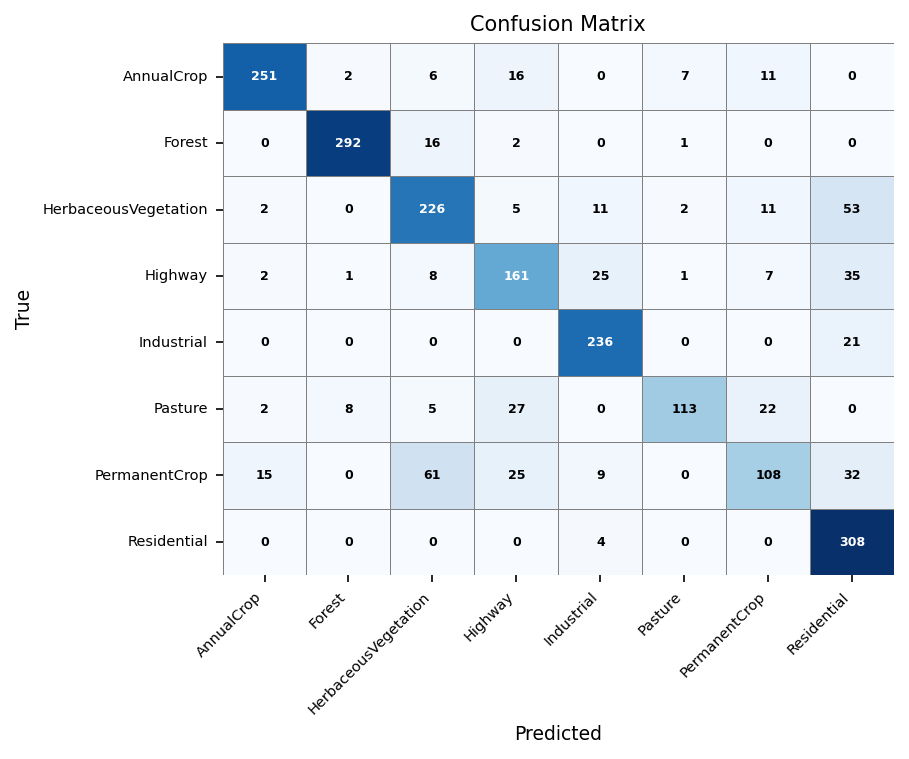

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# class labels
class_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
                'Industrial', 'Pasture', 'PermanentCrop', 'Residential']

# confusion matrix from results
cm = np.array([
    [251, 2, 6, 16, 0, 7, 11, 0],
    [0, 292, 16, 2, 0, 1, 0, 0],
    [2, 0, 226, 5, 11, 2, 11, 53],
    [2, 1, 8, 161, 25, 1, 7, 35],
    [0, 0, 0, 0, 236, 0, 0, 21],
    [2, 8, 5, 27, 0, 113, 22, 0],
    [15, 0, 61, 25, 9, 0, 108, 32],
    [0, 0, 0, 0, 4, 0, 0, 308]
])

fig, ax = plt.subplots(figsize=(6, 5), dpi=150)  # smaller size
sns.heatmap(cm, cmap="Blues", ax=ax, cbar=False,  # removed colorbar for compactness
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.3, linecolor='gray')

# Labels and title
ax.set_xlabel('Predicted', fontsize=9)
ax.set_ylabel('True', fontsize=9)
ax.set_title('Confusion Matrix', fontsize=10)

# Ticks
ax.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(class_labels, rotation=0, fontsize=7)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if value > cm.max() * 0.5 else "black"
        ax.text(j + 0.5, i + 0.5, f"{value}", ha='center', va='center',
                color=color, fontsize=6, fontweight='bold')

plt.tight_layout(pad=0.5)
plt.show()



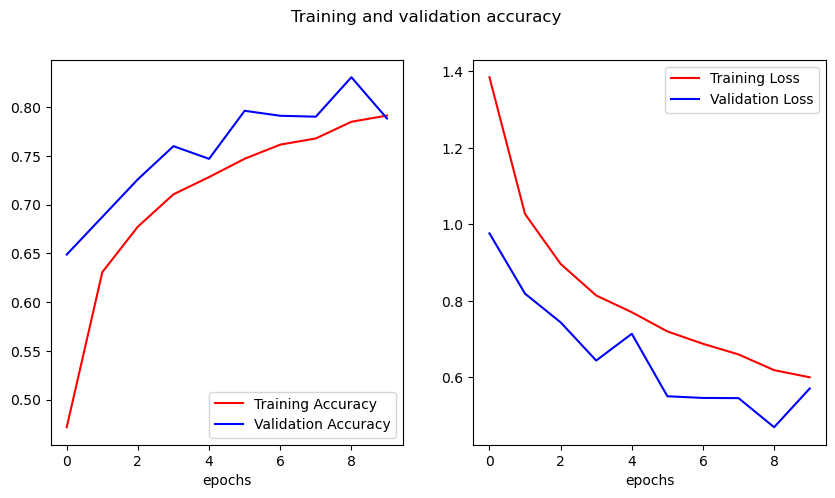

In [31]:
import matplotlib.pyplot as plt
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

Resnet 50

In [16]:
pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(150,150,3),
    pooling= "max",
    classes=8,
    weights="imagenet"
)

In [17]:
from tensorflow.keras.applications import ResNet50


In [18]:
pretrained_model.trainable = False

In [19]:
def create_model2():
    model_resnet= tf.keras.models.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation="softmax")
    ])
    
    model_resnet.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model_resnet

In [20]:
model_resnet= create_model2()

In [21]:
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24640904 (94.00 MB)
Trainable params: 1053192 (4.02 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

# Train ResNet model
with tf.device('/GPU:0'):
    history2 = model_resnet.fit(
        training_dataset,
        epochs=10,
        validation_data=validation_dataset
    )

# Get true labels and predictions
y_true_resnet = []
y_pred_resnet = []

for x, y in validation_dataset:
    preds = model_resnet.predict(x)
    y_true_resnet.extend(np.argmax(y.numpy(), axis=1))
    y_pred_resnet.extend(np.argmax(preds, axis=1))

# Compute metrics
print("Classification Report (ResNet):")
print(classification_report(y_true_resnet, y_pred_resnet, digits=4))

print("Confusion Matrix (ResNet):")
print(confusion_matrix(y_true_resnet, y_pred_resnet))


Epoch 1/10
605/605 [==============================] - 502s 820ms/step - loss: 0.5231 - accuracy: 0.8693 - val_loss: 0.1789 - val_accuracy: 0.9423
Epoch 2/10
605/605 [==============================] - 498s 824ms/step - loss: 0.2588 - accuracy: 0.9165 - val_loss: 0.1618 - val_accuracy: 0.9488
Epoch 3/10
605/605 [==============================] - 405s 669ms/step - loss: 0.2224 - accuracy: 0.9275 - val_loss: 0.1522 - val_accuracy: 0.9544
Epoch 4/10
605/605 [==============================] - 417s 689ms/step - loss: 0.1956 - accuracy: 0.9356 - val_loss: 0.1509 - val_accuracy: 0.9530
Epoch 5/10
605/605 [==============================] - 484s 801ms/step - loss: 0.1820 - accuracy: 0.9399 - val_loss: 0.1400 - val_accuracy: 0.9605
Epoch 6/10
605/605 [==============================] - 447s 738ms/step - loss: 0.1665 - accuracy: 0.9472 - val_loss: 0.1382 - val_accuracy: 0.9581
Epoch 7/10
605/605 [==============================] - 1342s 2s/step - loss: 0.1632 - accuracy: 0.9481 - val_loss: 0.1361 - v

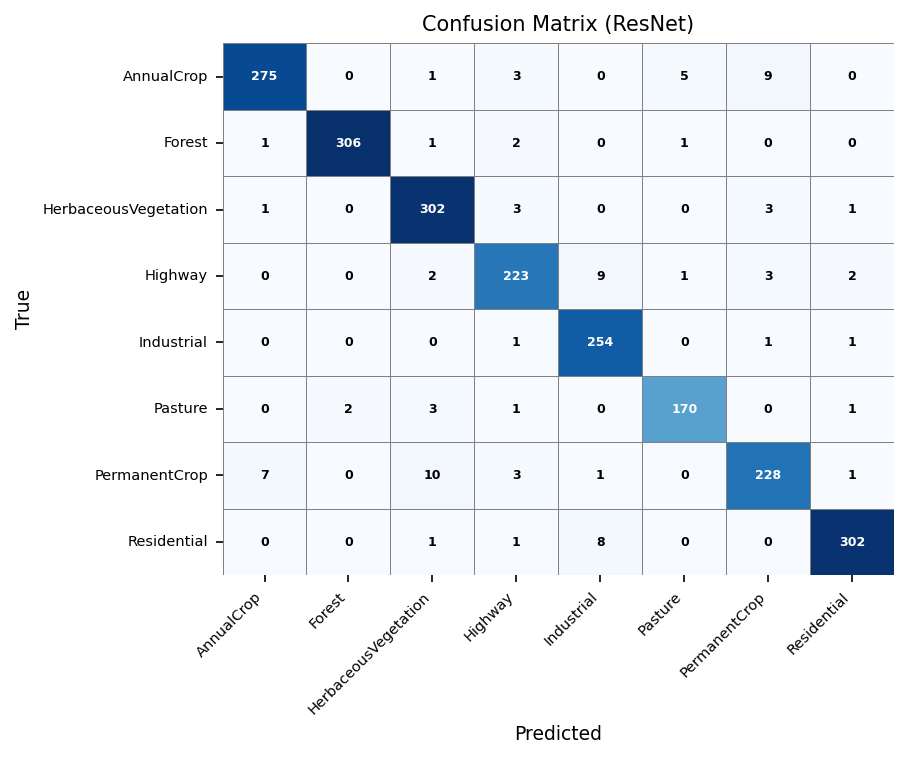

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# class labels
class_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
                'Industrial', 'Pasture', 'PermanentCrop', 'Residential']

# confusion matrix (ResNet)
cm = np.array([
    [275, 0, 1, 3, 0, 5, 9, 0],
    [1, 306, 1, 2, 0, 1, 0, 0],
    [1, 0, 302, 3, 0, 0, 3, 1],
    [0, 0, 2, 223, 9, 1, 3, 2],
    [0, 0, 0, 1, 254, 0, 1, 1],
    [0, 2, 3, 1, 0, 170, 0, 1],
    [7, 0, 10, 3, 1, 0, 228, 1],
    [0, 0, 1, 1, 8, 0, 0, 302]
])

# Compact confusion matrix plot
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
sns.heatmap(cm, cmap="Blues", ax=ax, cbar=False,
            xticklabels=class_labels, yticklabels=class_labels,
            linewidths=0.3, linecolor='gray')

# Labels and title
ax.set_xlabel('Predicted', fontsize=9)
ax.set_ylabel('True', fontsize=9)
ax.set_title('Confusion Matrix (ResNet)', fontsize=10)

# Ticks
ax.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(class_labels, rotation=0, fontsize=7)

# Annotate each cell with smaller font
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        color = "white" if value > cm.max() * 0.5 else "black"
        ax.text(j + 0.5, i + 0.5, f"{value}", ha='center', va='center',
                color=color, fontsize=6, fontweight='bold')

plt.tight_layout(pad=0.5)
plt.show()


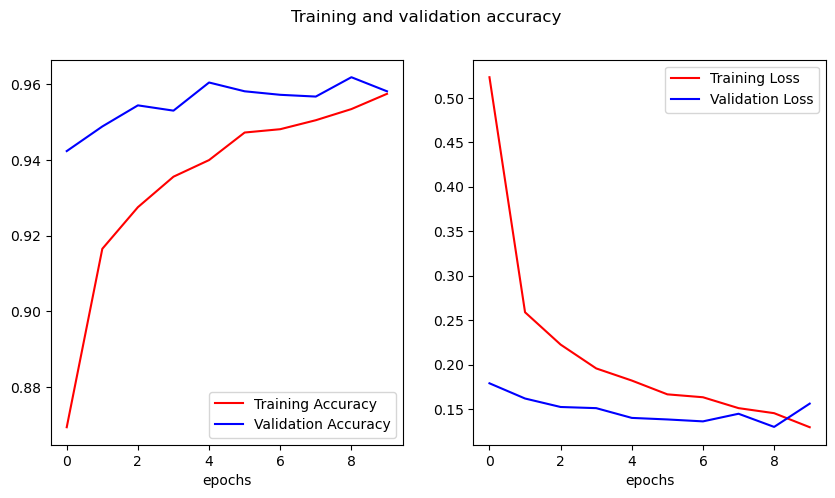

In [32]:
import matplotlib.pyplot as plt
# Get training and validation accuracies
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc2, val_acc2), (loss2, val_loss2)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [63]:
model.save(r"D:\University\sem5\Deep Learning")

INFO:tensorflow:Assets written to: D:\University\sem5\Deep Learning\assets


INFO:tensorflow:Assets written to: D:\University\sem5\Deep Learning\assets


In [67]:
model.save("model1.h5")  # saves entire model in HDF5


In [69]:
model_resnet.save("model_resnet.h5")

C:\Users\asus\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
import json

# Save history as JSON
with open("history.json", "w") as f:
    json.dump(history.history, f)


In [71]:
import json

# Save history as JSON
with open("history2.json", "w") as f:
    json.dump(history2.history, f)
